Loading the data processed by hdWGCNA in R

In [1]:
import math
import seaborn as sns
import numpy as np
import scanpy as sc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [2]:
expr_path = "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/WMB-10Xv3/20230630/processed/WMB-10Xv3-Isocortex-1-log2-wmeta.h5ad"
adata = sc.read_h5ad(expr_path)
adata

AnnData object with n_obs × n_vars = 227670 × 32285
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'region_of_interest_order', 'region_of_interest_color'
    var: 'gene_symbol'

In [ ]:
modules_df = pd.read_csv(
    "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/WMB-10Xv3/20230630/outputs/WMB-10Xv3-Isocortex-1-raw-sc-wgcna-modules.csv",
    index_col = "Unnamed: 0")
print("All module colors (names): ", modules_df["color"].unique())
modules_df.head()

All module colors (names):  ['green' 'brown' 'grey' 'blue' 'turquoise' 'yellow' 'red']


,gene_name,module,color,kME_green,kME_brown,kME_grey,kME_blue,kME_turquoise,kME_yellow,kME_red
ENSMUSG00000015090,ENSMUSG00000015090,green,green,0.653472,-0.032236,-0.115646,0.123502,0.069904,0.154395,-0.175664
ENSMUSG00000031425,ENSMUSG00000031425,green,green,0.921549,-0.047739,-0.106292,0.077948,0.088522,0.202247,-0.212231
ENSMUSG00000115529,ENSMUSG00000115529,green,green,0.283788,-0.010976,-0.029480,0.021220,0.017650,0.086082,-0.085927
ENSMUSG00000029819,ENSMUSG00000029819,brown,brown,-0.017231,0.547982,-0.066836,-0.008960,-0.004381,0.005224,-0.110663
ENSMUSG00000024610,ENSMUSG00000024610,grey,grey,0.007531,-0.025541,-0.034615,0.028825,0.155726,0.004847,-0.031323


## Module Eigengene of whole module

In [4]:
select_module = "green"
select_genes = modules_df[modules_df["module"] == select_module].index
print("Number of genes in the module: ", select_genes.shape[0])
common_genes = adata.var_names.intersection(select_genes)
adata_subset = adata[:,common_genes].copy()
adata_subset

Number of genes in the module:  119


AnnData object with n_obs × n_vars = 227670 × 119
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'region_of_interest_order', 'region_of_interest_color'
    var: 'gene_symbol'

In [5]:
# sc.pp.filter_cells(adata_subset, min_genes=1)
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
sc.pp.scale(adata_subset, max_value=10)
sc.tl.pca(adata_subset, n_comps = 2, svd_solver="arpack")
adata_subset.obs[select_module] = adata_subset.obsm['X_pca'][:,0]
adata_subset

/home/momo/miniforge3/envs/abca-env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


AnnData object with n_obs × n_vars = 227670 × 119
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'region_of_interest_order', 'region_of_interest_color', 'green'
    var: 'gene_symbol', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [6]:
def plot_umap(data, x_col="x", y_col="y", color_col="turquoise", fig_width=6, fig_height=6, cmap="viridis"):
    """
    Plots a UMAP visualization with a style similar to a minimal scatter plot.

    Parameters:
        data (pd.DataFrame): The dataframe containing UMAP coordinates and the column to color.
        x_col (str): Column name for the x-axis UMAP coordinate.
        y_col (str): Column name for the y-axis UMAP coordinate.
        color_col (str): Column name for the color values.
        fig_width (float): Width of the figure.
        fig_height (float): Height of the figure.
        cmap (str): Colormap for the scatter plot.

    Returns:
        fig, ax: Matplotlib figure and axis objects.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    # Scatter plot with small marker size
    scatter = ax.scatter(
        data[x_col],
        data[y_col],
        s=0.5,
        c=data[color_col],
        cmap=cmap,
        marker='.',
        edgecolor='none'
    )

    # Set equal axis aspect ratio
    ax.axis('equal')

    # Set limits for the plot
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a colorbar
    fig.colorbar(scatter, ax=ax, orientation='vertical', label=color_col)

    return fig, ax

(<Figure size 600x600 with 2 Axes>, <Axes: >)

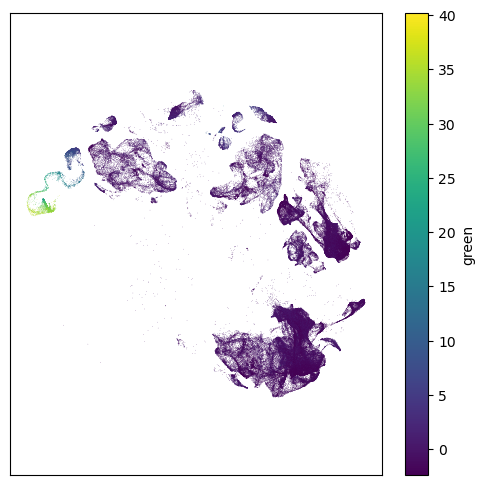

In [7]:
plot_umap(adata_subset.obs, color_col=select_module)

## Module eigengene of genes in common with the MERFISH panel

In [8]:
merfish_panel_df = pd.read_csv(
    "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/MERFISH-C57BL6J-638850/20230830/gene_panel.csv"
)
merfish_panel_df.head()

,gene_identifier,gene_symbol,transcript_identifier
0,ENSMUSG00000026778,Prkcq,ENSMUST00000028118
1,ENSMUSG00000026837,Col5a1,ENSMUST00000028280
2,ENSMUSG00000001985,Grik3,ENSMUST00000030676
3,ENSMUSG00000039323,Igfbp2,ENSMUST00000047328
4,ENSMUSG00000048387,Osr1,ENSMUST00000057021


In [9]:
select_genes = modules_df[modules_df["module"] == select_module].index
print("Number of genes in the module: ", select_genes.shape[0])
merfish_genes = select_genes.intersection(merfish_panel_df['gene_identifier'])
print("Number of module genes in the merfish panel: ", merfish_genes.shape[0])
adata_common = adata[:,merfish_genes].copy()
adata_common

Number of genes in the module:  119
Number of module genes in the merfish panel:  8


AnnData object with n_obs × n_vars = 227670 × 8
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'region_of_interest_order', 'region_of_interest_color'
    var: 'gene_symbol'

In [10]:
# sc.pp.filter_cells(adata_common, min_genes=1)
sc.pp.normalize_total(adata_common, target_sum=1e4)
sc.pp.log1p(adata_common)
sc.pp.scale(adata_common, max_value=10)
sc.tl.pca(adata_common, n_comps = 2, svd_solver="arpack")
adata_common.obs[select_module] = adata_common.obsm['X_pca'][:,0]
adata_common

/home/momo/miniforge3/envs/abca-env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


AnnData object with n_obs × n_vars = 227670 × 8
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'region_of_interest_order', 'region_of_interest_color', 'green'
    var: 'gene_symbol', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

(<Figure size 600x600 with 2 Axes>, <Axes: >)

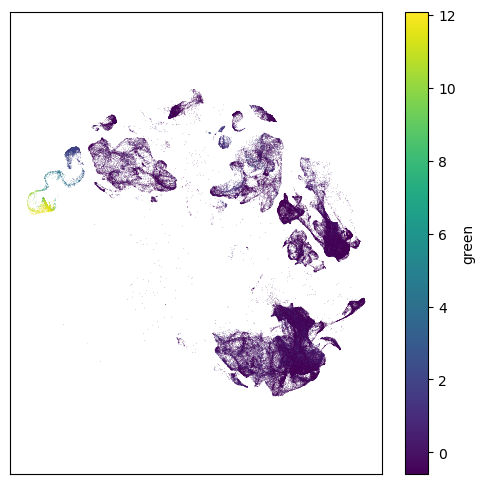

In [11]:
plot_umap(adata_common.obs, color_col=select_module)

## Correlation of full vs. subset-based eigengenes

In [12]:
from scipy.stats import pearsonr

partial_corr = pearsonr(adata_subset.obsm['X_pca'][:,0], adata_common.obsm['X_pca'][:,0])
partial_corr

PearsonRResult(statistic=np.float32(0.86774606), pvalue=np.float64(0.0))

**Permutation/Bootstrap test**

In [76]:
# del adata_subset, adata_common